In [173]:
#Experiment 1: varying sample size adding additive noise with std = 0.2

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

n = range(5,201, 5)
n_2 = range(0,100,1)
f = 2 # the frequency for sin signal


test_error = np.zeros([3,len(n)])
train_error = np.zeros([3,len(n)])
temp_test = np.zeros([3,len(n_2)])
temp_train = np.zeros([3,len(n_2)])
temp_L = np.zeros([3,len(n_2)])
Rad = np.zeros([3,len(n)])

for counter,value in enumerate(n): 
    for j in n_2:
        #step 1 - data generation
        fs = value #sample rate for sin signal
        X = np.vstack([[np.random.uniform(0,1,value).reshape(-1,1)],         
                       [np.random.uniform(0,1,value).reshape(-1,1)],
                       [np.arange(fs).reshape(-1,1)]])
        e = np.random.normal(0,0.2,value).reshape(-1,1)
        #Y in order linear, quadratic and sin
        Y = np.vstack([[(10.5*X[0] +5 + e).reshape(-1,1)],
                      [(10.5*X[1] + 90*X[1]**2 +5 + e).reshape(-1,1)],
                       [np.sin(2*np.pi*f*(X[2]/fs)).reshape(-1,1)]])
    
        #shuffling sin
        idx = np.random.permutation(Y[2].shape[0])
        X[2]= X[2,idx]
        Y[2]= Y[2,idx]    
        
        #train split 
        X_train, X_test = np.hsplit(X, [int(.8*int(X.shape[1]))])
        Y_train, Y_test = np.hsplit(Y, [int(.8*int(Y.shape[1]))])
        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
        
        #rademacher sigma
        s = np.random.binomial(1,0.5, int(Y_train[0].shape[0]))
        a = sum(s)
        while a.all() !=0:
            s = np.random.binomial(1,0.5, int(Y_train[0].shape[0]))
            s[s < 1] = -1
            a = sum(s)
        
        for i in range(0,3,1):
            
            #Step 2: model fitting
            #initialisation of linear regression/insert data for training/prediction
            m = LinearRegression()

            #inserting train data in model for training
            m.fit(X_train[i],Y_train[i])

            #predicting values for test data
            Y_pred_test[i] = m.predict(X_test[i])
            Y_pred_train[i] = m.predict(X_train[i])

            #computing RMSE
            error_test= np.sqrt(mean_squared_error(Y_test[i], Y_pred_test[i]))
            temp_test[i,j] =  error_test

            error_train= np.sqrt(mean_squared_error(Y_train[i], Y_pred_train[i]))
            temp_train[i,j] = error_train
            
            #Rademacher constant
            L = (2*np.dot(s, np.sqrt((Y_train[i]-Y_pred_train[i])**2)))/len(Y_train[i])
            temp_L[i,j] = L

    test_error[:,counter] = np.mean(temp_test, axis = 1)
    train_error[:,counter] = np.mean(temp_train, axis = 1)
    Rad[:,counter] = np.amax(temp_L, axis = 1)    

In [174]:
#Calculating Rademacher bound for regression
bound = np.zeros([3,len(n)])
delta = 0.1
c1 = 3*(np.sqrt(np.log(2/delta)/(2*np.array(n))))
for i in range(0,3):
    bound[i] = np.add(train_error[i], Rad[i])
    bound[i] = np.add(bound[i],c1)
print(bound)

#VC dimension
VC = np.zeros([3,len(n)])
c2 = np.array(n)/(2*np.log(n))
for i in range(0,3):
    VC[i] = (Rad[i]**2)*c2

#Calculating VC bound for regression
boundVC = np.zeros([3,len(n)])
delta = 0.1
a = VC[i]/np.array(n)
c3 = np.log(np.array(n))/(2*(np.array(n)))
for i in range(0,3):
    boundVC[i] = train_error[i]/(1- np.sqrt(a[i]-(a[i]*np.log(a[i]))+c3[i]))
print(bound)

[[ 1.99504229  1.53021513  1.28687815  1.15261341  1.00259797  0.97228587
   0.93896936  0.85672283  0.83596167  0.80925718  0.75487927  0.75744696
   0.74140418  0.71462857  0.68314455  0.67775948  0.65704917  0.66251522
   0.6520118   0.64396353  0.64500162  0.60825013  0.5965934   0.59846218
   0.60022251  0.5600671   0.57064428  0.57722228  0.55614278  0.55353291
   0.55499906  0.53664945  0.54662616  0.54872348  0.53491662  0.51836682
   0.5150572   0.51047933  0.50963728  0.50681135]
 [10.38749256 11.03615077 12.61323069 10.69244596 10.16792489  9.79108788
  10.4834166   9.07267281  9.5397324  10.01790824  9.3290318   9.07764621
   9.24507529  9.22552841  8.78247345  9.26495153  9.04583271  8.65046804
   8.75234725  8.71163146  8.38575274  9.14393063  8.96718191  8.88814579
   8.25474388  9.10407082  8.67504851  8.28322069  8.28035582  8.12789316
   8.47565672  8.50017652  8.17902127  8.24239063  8.66180032  8.29436481
   8.10640595  8.37524758  8.01962662  7.86082712]
 [ 2.98797

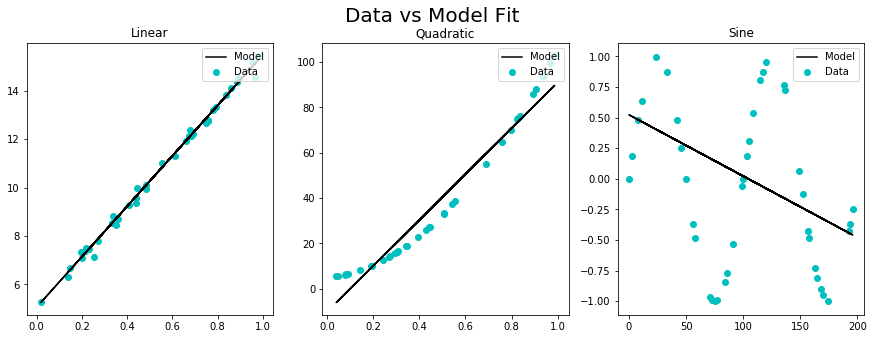

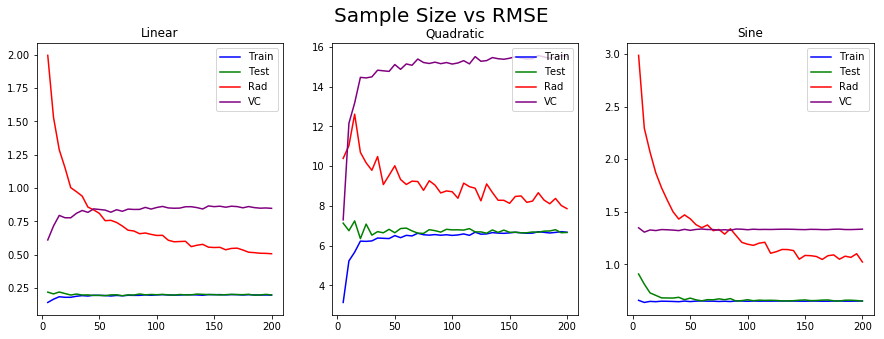

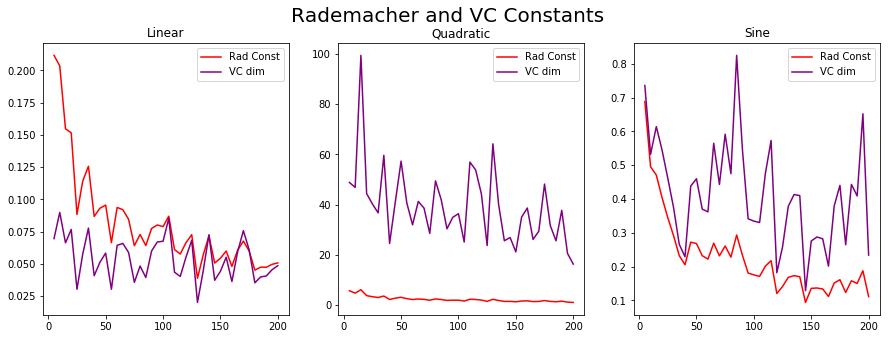

In [177]:
#Step 3: Evaluation
#Theory: Expect the model get better and better as sample size increase given bounds for VC dimension (test error decrease by a factor
#of aprox. sqrt(2m).
#Results: one can see that error indeed decreases with sample size, where irreducible error with little data for all 3 models.
#Error(linear) < error (quadratic) < error (sine)

import matplotlib.pyplot as plt

funcs = ["Linear", "Quadratic", "Sine"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Data vs Model Fit', fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].scatter(X_test[i],Y_test[i],color='c', label = 'Data')
    axes[i].plot(X_test[i], Y_pred_test[i], color = 'black', label = 'Model') 
    axes[i].legend(loc='upper right')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Sample Size vs RMSE',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    #axes[i].set_xscale('log')
    #axes[i].set_yscale('log')
    axes[i].plot(n,train_error[i],color='blue', label = 'Train')
    axes[i].plot(n,test_error[i],color = 'green', label = 'Test')
    axes[i].plot(n,bound[i], color = 'red', label = 'Rad')
    axes[i].plot(n,boundVC[i], color = 'purple', label = 'VC')
    axes[i].legend(loc='upper right')
plt.show()

#Rademacher
fig, axes = plt.subplots(1, 3, figsize = (15,5))
fig.suptitle('Rademacher and VC Constants',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].plot(n,Rad[i],color='red', label = "Rad Const")
    axes[i].plot(n,VC[i],color='purple', label = "VC dim")
    axes[i].legend(loc='upper right')
plt.show()


[[  5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90
   95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180
  185 190 195 200]]
[[0.22978764 0.20526297 0.20567927 0.21679012 0.19885739 0.19912984
  0.19573719 0.2031817  0.20553177 0.19237104 0.20445546 0.20566038
  0.20618262 0.19407672 0.20081081 0.20307591 0.20062286 0.19604917
  0.20678968 0.20006603 0.20229013 0.1994482  0.19721737 0.20215771
  0.20306073 0.20298874 0.20036034 0.20439202 0.20138272 0.19965255
  0.20277656 0.1985077  0.2006654  0.19462884 0.20171452 0.19348323
  0.19859873 0.19833071 0.20006367 0.20074702]
 [7.91130549 6.87442756 7.57367157 7.21435005 6.74394144 6.74313508
  6.78029981 7.10295408 6.8667441  6.94989557 6.6079268  6.64469213
  6.65359079 6.85915073 6.88518754 6.78759748 6.91092229 6.93591759
  6.81238047 6.90840522 6.69523856 6.59591278 6.74402184 6.63278686
  6.8196401  6.66257916 6.73401667 6.91293558 6.69594392 6.8371363
  6.72237074 6.72640959 6.64696042 6.7

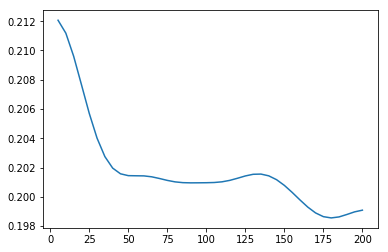

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    12.21      8.67268e+16       10       0.00221006       0.00101003      8.13s
   1     3.85       3.8305e+07        4       0.00419941       0.00352956      5.73s
   2     7.17      2.62855e+07        6       0.00330156       0.00760747      5.93s
   3     3.02      1.19306e+07        1       0.00232713       0.00528436      3.91s
   4     1.63      3.81325e+06        1       0.00239849       0.00464209      2.65s
   5     1.36      5.59656e+06        1       0.00198246       0.00838633      2.03s
   6     1.32      4.59609e+06        1        0.0019097       0.00904121      1.65s
   7     1.40      1.23947e+07        1       0.00187952       0.00931279      1.27s
   8     1.34      2.37485e+06        1       0.00189703       0.00915522      0.55s
   9     1.42       5.5517e+07        1       0.00172394         0.010713      0.00s
0.199


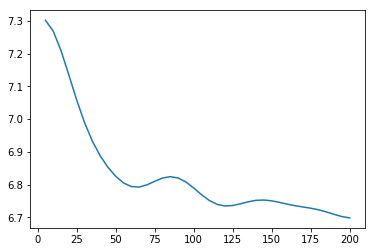

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


   0    12.22      2.42288e+15       14         0.301447         0.201575      7.68s
   1     3.92      3.49484e+07        4         0.118543          0.18185      6.23s
   2     2.29      6.96827e+06        3        0.0931881          0.12244      4.55s
   3     1.48      5.87935e+06        3         0.942746         0.903865      3.50s
   4     1.36       4.2594e+06        3          1.12942          1.11279      2.91s
   5     1.44      1.00462e+10        9          1.79041           1.5323      2.38s
   6     1.37      8.39276e+06       20         0.572254         0.473529      1.92s
   7     1.39      6.12286e+06        6          1.55367          1.11645      1.18s
   8     1.31      7.54229e+07        6          2.39565          3.42442      0.55s
   9     1.42      6.99414e+06        8          1.33533          1.19401      0.00s
abs(log(add(log(X0), div(X0, -0.312))))


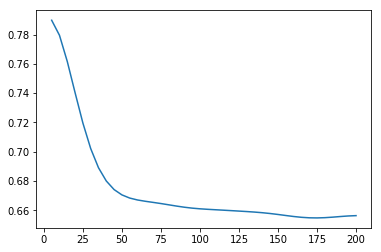

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:144: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x1) > 0.001, 1. / x1, 0.)


   0    12.64      1.85763e+16        5        0.0170881         0.047155      8.85s
   1     3.88      1.11584e+08        4        0.0151075        0.0720861      6.54s
   2     2.22      7.35498e+06        3        0.0165728        0.0284461      4.88s
   3     1.51      1.86426e+11        1        0.0167641        0.0571772      4.35s
   4     1.44      5.62231e+07        1        0.0153449        0.0699495      3.24s
   5     1.34      5.69275e+06        1        0.0133886        0.0875567      2.21s
   6     1.34      3.66221e+07        1        0.0138841        0.0830972      1.83s
   7     1.32      1.04164e+07        1        0.0139484        0.0825187      1.19s
   8     1.35      6.86929e+09        1        0.0134095        0.0793385      0.59s
   9     1.36      1.49415e+10        1        0.0149537        0.0734706      0.00s
0.671


In [159]:
#Symbolic Regression
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

# Create custom operations (exp) to be considered in the tree
def _xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a    

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt',  'abs', 'neg', 'inv', xexp]
est_gp = SymbolicRegressor(population_size=2000, init_method = 'grow',
                           tournament_size = 10, generations=10, 
                           stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient='auto', random_state=None,
                           function_set = f_set)

# #linear 0.206
# #quadratic: add(xexp(xexp(0.584)), xexp(-0.229))
# #sin 0.060
sample = []
for i in n: 
    sample.append(i)  
sample = np.array([sample])


print(sample)
print(test_error)

for i in range(0,3):
    plt.plot(sample.reshape(-1,1),test_error[i])
    plt.show()
    est_gp.fit(sample.reshape(-1,1),test_error[i])
    print(est_gp._program)



In [160]:
#Experiment 2: varying  model capacity adding additive noise with std = 0.2, fixing 100 data points
#Theory: Expect model get worse as model capacity increases for a true linear model, as we increase model capactiy 
#by adding polynomials, we increase the VC dimension, which makes the error bound for the true model to be 
#more loose than it should be.

# Resuls: 
#Linear: as expected, as we increase model capacity we get worse RMSE given that the true function is linear.
# The more capacity the lower the bias; the less the bias the better the ability to fit data well, which increases variance.
#Quadratic: once polinomials of power 2 are added, increasing capacity have no much effect in the error.
#Sine: got consistent experimental results that is well aprox by polynomials degree 7.  

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

samples = 200
n_2 = range(0,100,1)
f = 2 # the frequency for sin signal
fs = samples #sample rate for sin signal
pw = range(1,11,1)

test_errorp = np.zeros([3,len(pw)])
train_errorp = np.zeros([3,len(pw)])
Radp = np.zeros([3,len(pw)])
temp_testp = np.zeros([3,len(n_2)])
temp_trainp = np.zeros([3,len(n_2)])
temp_Lp = np.zeros([3,len(n_2)])
X_poly = []
h = 0

for i in pw:
#     print(i)
    for j in n_2:
        #step 1 - data generation        
        X = np.vstack([[np.random.uniform(0,1,samples).reshape(-1,1)],         
                       [np.random.uniform(0,1,samples).reshape(-1,1)],
                       [np.arange(fs).reshape(-1,1)]])
        e = np.random.normal(0,0.2,samples).reshape(-1,1)
        #Y in order linear, quadratic and sin
        Y = np.vstack([[(10.5*X[0] +5 + e).reshape(-1,1)],
                      [(10.5*X[1] + 90*X[1]**2 +5 + e).reshape(-1,1)],
                       [np.sin(2*np.pi*f*(X[2]/fs)).reshape(-1,1)]])
        

        #shuffling 
        idx = np.random.permutation(Y[0].shape[0])
        for i in range(0,3,1):
            X[i] = X[i,idx]
            Y[i] = Y[i,idx]

        #y split
        Y_train, Y_test = np.hsplit(Y, [int(.8*int(Y.shape[1]))])
#         print("Y")
#         print(Y)
#         print("Y train")
#         print(Y_train)
#         print("Y test")
#         print(Y_test)
        Y_pred_trainp = np.empty_like(Y_train)
        Y_pred_testp = np.empty_like(Y_test)
        for k in range(0,3,1):
            #calculating polinomial features from 1 to 16 degree
            poly = PolynomialFeatures(degree = h+1) 
            X_poly = poly.fit_transform(X[k])  
#             print("X")
#             print(X)
#             print("X[k]")
#             print(X[k])
#             print("X_poly")
#             print(X_poly)

            #x split
            X_train, X_test = np.vsplit(X_poly, [int(.8*int(X.shape[1]))])
#             print("X_train")
#             print(X_train)
#             print("X_test")
#             print(X_test)

            #rademacher sigma
            s = np.random.binomial(1,0.5, int(Y_train[k].shape[0]))
            a = sum(s)
            while a.all() !=0:
                s = np.random.binomial(1,0.5, int(Y_train[k].shape[0]))
                s[s < 1] = -1
                a = sum(s)
                
#             print("s")
#             print(s)

            #Step 2: model training
            #fitting model
            #poly.fit(X_train.reshape(1, -1), Y_train[k])
            
            mp = LinearRegression()
            
            #inserting train data in model for training
            mp.fit(X_train,Y_train[k])

            #predicting values for test data
            Y_pred_testp[k] = mp.predict(X_test)
            Y_pred_trainp[k] = mp.predict(X_train)
            
#             print("Y_pred_trainp")
#             print(Y_pred_trainp)

            #computing RMSE
            error_testp = np.sqrt(mean_squared_error(Y_test[k], Y_pred_testp[k]))
            temp_testp[k,j] =  error_testp
            

            error_trainp = np.sqrt(mean_squared_error(Y_train[k], Y_pred_trainp[k]))
            temp_trainp[k,j] = error_trainp
            
#             print("errortrainp")
#             print(error_trainp)
            
            #Rademacher constant
            Lp = (2*np.dot(s, np.sqrt((Y_train[k]-Y_pred_trainp[k])**2)))/len(Y_train[k])
            temp_Lp[k,j] = Lp

#     print("temp_trainp")
#     print(temp_trainp)
    test_errorp[:, h] = np.mean(temp_testp, axis = 1) 
    train_errorp[:,h] = np.mean(temp_trainp, axis = 1)
#     print("train_errorp")
#     print(train_errorp)
    Radp[:,h] = np.amax(temp_Lp, axis = 1)   
    h = h+1

In [161]:
#Calculating Rademacher bound for regression
boundp = np.zeros([3,len(pw)])
delta = 0.1
a = np.ones(len(pw))*(3*(np.sqrt(np.log(2/delta)/samples)))
for i in range(0,3):
    boundp[i] = np.add(train_errorp[i], Radp[i])
    boundp[i] = np.add(boundp[i],a)
print(boundp)

#VC dimension
VCp = np.zeros([3,len(pw)])
c2p = samples/(2*np.log(samples)) #N/2*ln(N)
for i in range(0,3):
    VCp[i] = (Radp[i]**2)*c2p

print(VCp)
#Calculating VC Bound for regression
boundVCp = np.zeros([3,len(pw)])
delta = 0.1
ap = VCp[i]/samples #h/N
print(ap)
c3p = np.log(samples)/(2*samples)
for i in range(0,3):
    boundVCp[i] = train_errorp[i]/(1- np.sqrt(ap[i]-(ap[i]*np.log(ap[i]))+c3p))
print(boundVCp)

[[0.61246837 0.62411588 0.60886642 0.601861   0.60899155 0.60904972
  0.6154222  0.60171325 0.59527773 0.60251791]
 [8.7020424  0.60598877 0.61128404 0.61723721 0.60744131 0.60573339
  0.6096003  0.59269386 0.61315444 0.61500323]
 [1.14484369 1.12891744 1.06857683 1.05714626 0.61698037 0.62177867
  0.41182084 0.57253016 0.61378099 0.58239299]]
[[4.17922723e-02 6.45901536e-02 3.84581937e-02 2.64109888e-02
  4.06832073e-02 4.18286114e-02 5.15071915e-02 3.22552840e-02
  2.47536010e-02 3.57167288e-02]
 [5.19476921e+01 3.05204882e-02 4.24691371e-02 5.29600165e-02
  3.79096983e-02 3.67564102e-02 4.13887170e-02 1.99424951e-02
  5.40676847e-02 6.01576074e-02]
 [3.11248717e-01 2.38806062e-01 2.17051794e-01 1.75965958e-01
  2.26723054e-02 3.07221571e-02 9.37362225e-04 2.42336722e-02
  4.07632410e-02 5.31138124e-02]]
[1.55624359e-03 1.19403031e-03 1.08525897e-03 8.79829790e-04
 1.13361527e-04 1.53610785e-04 4.68681112e-06 1.21168361e-04
 2.03816205e-04 2.65569062e-04]
[[0.23536283 0.23560528 0.23


RMSE linear:  [0.19886186 0.19679774 0.20269045 0.20631604 0.20029539 0.20406256
 0.20644071 0.20396384 0.206973   0.20898678]

RMSE quadratic:  [6.73363668 0.19714644 0.2021802  0.20572474 0.19942087 0.20296988
 0.20780526 0.20527638 0.20488434 0.212342  ]

RMSE sine:  [0.66037707 0.66051816 0.61239837 0.6182957  0.22526796 0.22893906
 0.04285645 0.18076217 0.20811434 0.16213693]


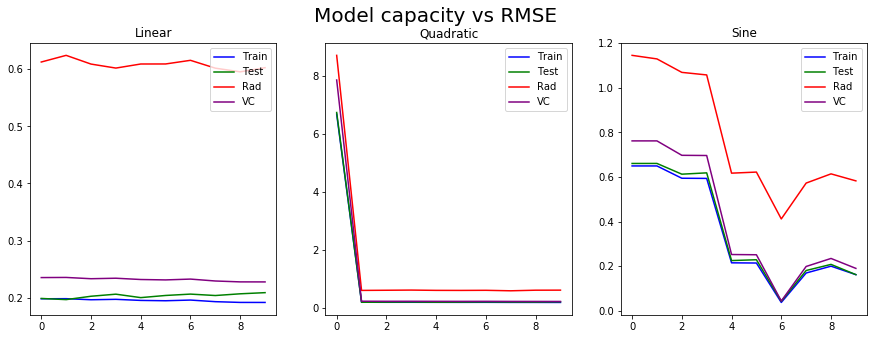

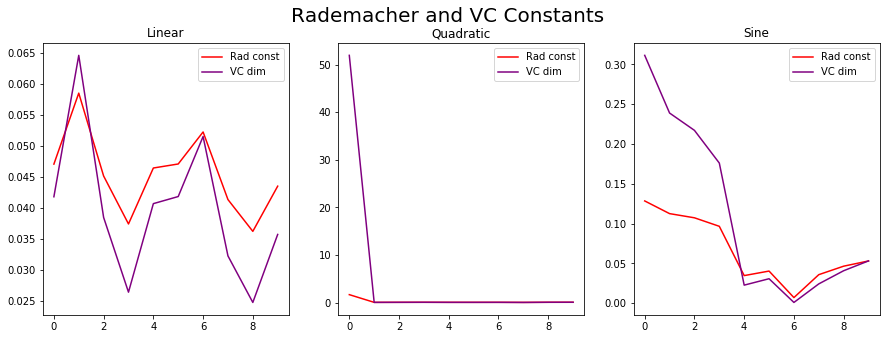

In [178]:
#Step 3: Evaluation
import matplotlib.pyplot as plt

print("\nRMSE linear: ", test_errorp[0])
print("\nRMSE quadratic: ", test_errorp[1])
print("\nRMSE sine: ", test_errorp[2])

funcs = ["Linear", "Quadratic", "Sine"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Model capacity vs RMSE',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    #axes[i].set_xscale('log')
    #axes[i].set_yscale('log')
    axes[i].plot(pw,train_errorp[i],color='blue', label = 'Train')
    axes[i].plot(pw,test_errorp[i],color = 'green', label = 'Test')
    axes[i].plot(pw,boundp[i], color = 'red', label = 'Rad')
    axes[i].plot(pw,boundVCp[i], color = 'purple', label = 'VC')
    axes[i].legend(loc='upper right')
plt.show()

#Rademacher
fig, axes = plt.subplots(1, 3, figsize = (15,5))
fig.suptitle('Rademacher and VC Constants',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].plot(pw,Radp[i],color='red', label = 'Rad const')
    axes[i].plot(pw,VCp[i],color='purple', label = 'VC dim')
    axes[i].legend(loc='upper right')
plt.show()


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[[0.19886186 0.19679774 0.20269045 0.20631604 0.20029539 0.20406256
  0.20644071 0.20396384 0.206973   0.20898678]
 [6.73363668 0.19714644 0.2021802  0.20572474 0.19942087 0.20296988
  0.20780526 0.20527638 0.20488434 0.212342  ]
 [0.66037707 0.66051816 0.61239837 0.6182957  0.22526796 0.22893906
  0.04285645 0.18076217 0.20811434 0.16213693]]


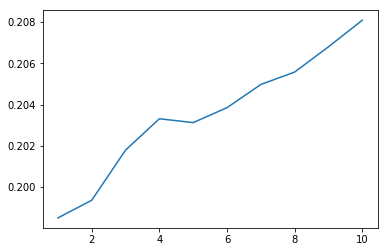

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


   0    12.58      8.10382e+07        5       0.00254871      0.000233763      7.77s
   1     4.01      1.38047e+06        4       0.00225954       0.00692457      5.61s
   2     2.28          124.461        2       0.00225954       0.00692457      5.14s
   3     1.44          166.867        2       0.00830691        0.0119281      3.60s
   4     1.34      1.14112e+06        4        0.0477369        0.0441156      2.55s
   5     1.42           333363        2       0.00527228        0.0108611      2.07s
   6     1.39           616145        3        0.0101494        0.0065282      1.54s
   7     1.37      2.97851e+06        1        0.0135556        0.0191445      1.09s
   8     1.37           360898        1        0.0135556        0.0191445      0.51s
   9     1.40          4232.73        1        0.0135556        0.0191445      0.00s
0.218


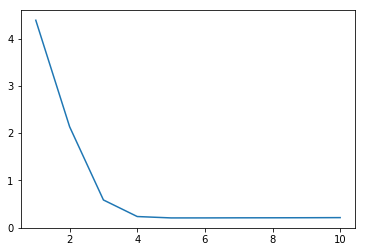

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


   0    12.68      1.64981e+17       28         0.179996          1.48702      7.06s
   1     4.03       6.6321e+06        2         0.254502          3.38681      5.30s
   2     2.35           362798        2         0.254502          3.38681      3.96s
   3     1.47          216.144        2         0.254502          3.38681      3.06s
   4     1.41           835494        2         0.254502          3.38681      2.97s
   5     1.36           912548        1         0.271606          4.19347      2.55s
   6     1.37           333856        6         0.213258          2.96876      1.55s
   7     1.37           282522        1         0.263869          4.16648      1.04s
   8     1.37           393429        1         0.263869          4.16648      0.54s
   9     1.39           484935        2         0.254502          3.38681      0.00s
inv(X0)


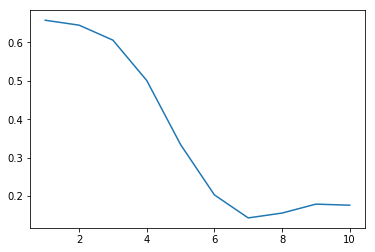

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:144: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x1) > 0.001, 1. / x1, 0.)


   0    13.07      3.51577e+14        6        0.0787548         0.461691      8.19s
   1     3.96      3.97575e+06        9         0.054926         0.086582      5.00s
   2     2.24           728696        4        0.0864644         0.271189      3.98s
   3     1.45      1.11437e+06        4        0.0846475          2.21996      3.79s
   4     1.44           862714        6         0.120411         0.272268      3.14s
   5     1.36      3.00921e+06       13         0.109885        0.0054993      2.53s
   6     1.37          31126.4       17         0.102269         0.028821      1.80s
   7     1.35           809179        6         0.112534         0.538711      1.27s
   8     1.29           780968        4        0.0840282          1.96249      0.64s
   9     1.42           833525        3         0.135763         0.134098      0.00s
abs(inv(X0))


In [163]:
#Symbolic Regression
#linear: 0.207
#quadratic: div(xexp(0.913), sub(X0, log(X0))) e^0.913/(power - log(power))
#sin: sin(sin(sin(xexp(mul(X0, -0.184)))))

f_set = function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt',  'abs', 'neg', 'inv', xexp]
est_gp = SymbolicRegressor(population_size=2000, init_method = 'grow',
                           tournament_size = 10, generations=10, 
                           stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient='auto', random_state=None,
                           function_set = f_set)

power = []
for i in pw: 
    power.append(i)  
print(power)
power = np.array([power])
print(test_errorp)
for i in range(0,3):
    plt.plot(power.reshape(-1,1),test_errorp[i])
    plt.show()
    est_gp.fit(power.reshape(-1,1), test_errorp[i])
    print(est_gp._program)

In [128]:
a = []
for i in pw:
    a.append(i)

error= list(test_errorp[0])

for i in range(0,10):
    print('{%s, ' %a[i] + '%s}' %error[i])
#print(test_error[0].shape)


{1, 0.20282046196951622}
{2, 0.1989108410810849}
{3, 0.20126716833107675}
{4, 0.20127822870454026}
{5, 0.19932389604523096}
{6, 0.2020450377054661}
{7, 0.20590103056335501}
{8, 0.20406487800679382}
{9, 0.2048722565013005}
{10, 0.20822065373253829}


In [164]:
#Experiment 3: Varying model capacity[0,9] and sample size [5,200]. 
#Want to approx a cubic, what is the best polynomial? What is the best sample size?

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import numpy as np

n = range(5,200, 10)
pw = range(0,10,1)
test_error = np.zeros([len(pw),len(n)])
train_error = np.zeros([len(pw),len(n)])
Rad = np.zeros([len(pw),len(n)])
temp = []
temp2= []
temp_train = []
temp2_train = []
temp_L = []
temp_L2 = []
for counter,value in enumerate(n): 
    for i in pw:
        for j in range(1,40):

            #step 1 - data generation        
            x = np.random.uniform(0,1,value).reshape(-1,1)
            e = np.random.normal(0,0.2,value).reshape(-1,1)
            #true function
            y = (10.5*x + 30*x**2 + 40*x**3 + e).reshape(-1,1) #cubic
            #shuffling data
            idx = np.random.permutation(y.shape[0])
            x= x[idx]
            y = y[idx]

            #creating polynomialfeatures
            poly = PolynomialFeatures(degree = i) 
            x_poly = poly.fit_transform(x) 

            #train split 
            x_train, x_test = np.split(x_poly, [int(.8*len(x))])
            y_train, y_test = np.split(y, [int(.8*len(y))])

            #rademacher sigma
            s = np.random.binomial(1,0.5, len(y_train))
            a = sum(s)
            while a.all() !=0:
                s = np.random.binomial(1,0.5, len(y_train))
                s[s < 1] = -1
                a = sum(s)
            
            #step 2 - model training
            #initialisation of linear regression 
            m = LinearRegression()

            #inserting train data in model for training
            m.fit(x_train,y_train)

            #predicting values for test data
            y_pred = m.predict(x_test)
            y_pred_train = m.predict(x_train)

            #computing RMSE for train and test
            error = np.sqrt(mean_squared_error(y_test, y_pred))
            temp.append(error) 
            error_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            temp_train.append(error_train)
            
            #computing Rademacher constant
            L = (2*np.dot(s, np.sqrt((y_train-y_pred_train)**2)))/len(y_train)
            temp_L.append(L)


        temp2.append(sum(temp) / len(temp))
        temp2_train.append(sum(temp_train)/len(temp_train))
        temp_L2.append(max(temp_L))
        temp.clear()
        temp_train.clear()
        temp_L.clear()
    test_error[:,counter] = temp2
    train_error[:,counter] = temp2_train
    Rad[:,counter] = temp_L2
    temp2.clear()
    temp2_train.clear()
    temp_L2.clear()



In [165]:
#Calculating Rademacher bound for regression
boundnp = np.zeros([len(pw),len(n)])
delta = 0.1
a = np.ones([len(pw),len(n)])*(3*(np.sqrt(np.log(2/delta)/n)))
boundnp = np.add(train_error, Rad)
boundnp = np.add(boundnp,a)
print(boundnp)

#VC dimension
VCnp = np.zeros([len(pw),len(n)])
c2np = n/(2*np.log(n)) #N/2*ln(N)
VCnp = (Rad**2)*c2np
print(VCnp)

#Calculating VC Bound for regression
boundVCnp = np.zeros([len(pw),len(n)])
anp = VCnp/np.array(n) #h/N
print(anp.shape)
print(anp)
c3np = np.ones([len(pw),len(n)])*(np.log(np.array(n))/(2*np.array(n)))
print(c3np)
boundVCnp = train_error/(1- np.sqrt(anp-(anp*np.log(anp))+c3np))
print(boundVCnp)

[[35.67392651 35.36214866 37.65068995 32.55120577 34.42237665 32.33408258
  31.80178351 28.56585001 30.62091224 27.77324293 29.56477162 28.41936475
  28.52548354 29.38161053 27.45118471 27.34309347 28.42473815 26.64328022
  27.9999628  28.18997084]
 [ 9.02312064 10.87201786 11.065763    9.95866395  9.480736    9.71926721
   9.46116391  8.22729764  8.10635001  9.39712479  8.99988055  8.67882095
   8.82916679  8.12809133  8.1741901   8.73527252  7.69811103  8.27549316
   8.2300005   8.07081108]
 [ 2.88038625  2.33949694  2.0307556   2.00744355  1.74738129  1.62305607
   1.62141367  1.63939939  1.57891942  1.49432642  1.45694462  1.44363792
   1.39300377  1.29280954  1.36793236  1.3331601   1.39676131  1.28870126
   1.28588967  1.27889581]
 [ 2.32213654  1.62931969  1.27631139  1.16960068  1.0382384   0.95646008
   0.9255402   0.84563677  0.81791297  0.77936904  0.75327418  0.71882729
   0.69597018  0.68499282  0.66584537  0.6611302   0.64940994  0.63976476
   0.62223717  0.6070657 ]
 [ 2

c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


Min RMSE:  0.19068344867491144
Position of min RMSE:  (array([3], dtype=int64), array([11], dtype=int64))
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195]

Min RMSE for each polynomial 
[21.26509363  6.42764125  0.75544488  0.19068345  0.19077356  0.1998931
  0.19620594  0.19776553  0.19859214  0.20240225]


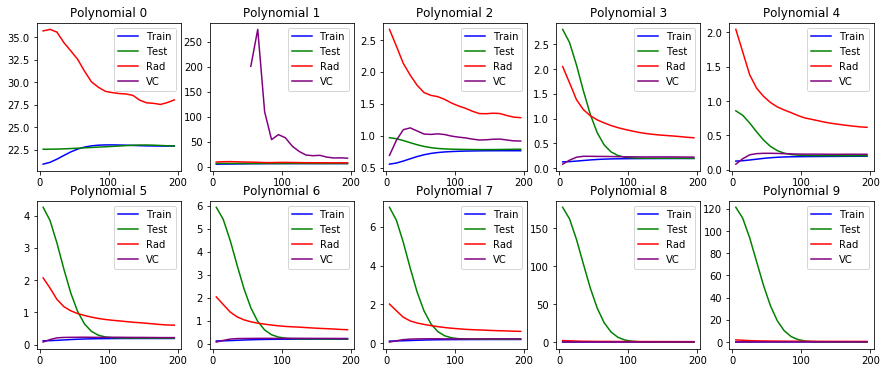

In [166]:
#Step 3: evaluation
#Theory: would expect that polynomial with degree 3 would be the best aproximation for a cubic. The more data the better.
#Results: indeed polynomial with degree 3 got the min error but best result achieved with only 125, when the error curve 
#reaches a plateau.
#The lower degree polynomials (<3) achieve the highest error. Higher order polynomial achieve similar error bounds as for degree 3
#where even degrees require slightly more data.

import matplotlib.pyplot as plt

print("Min RMSE: ", np.amin(test_error))
pos = np.where(test_error== np.amin(test_error))
print('Position of min RMSE: ', pos)
print(list(pw))
print(list(n))

# plt.plot(n,test_error[3,:], color = 'c')
# plt.show()

print('\nMin RMSE for each polynomial ')
print(np.amin(test_error, axis = 1))

#plotting
fig, axs = plt.subplots(2,5, figsize=(15, 6))
axs = axs.flatten()
for i in pw:
    axs[i].plot(n, train_error[i,:], color = 'blue', label = 'Train')
    axs[i].plot(n, test_error[i,:], color = 'green', label = 'Test')
    axs[i].plot(n, boundnp[i], color = 'red', label = 'Rad')
    axs[i].plot(n,boundVCnp[i], color = 'purple', label = 'VC')
    axs[i].legend(loc='upper right')
    axs[i].set_title("Polynomial %d" %i)
plt.show()


In [172]:
#Symbolic Regression
#linear: 0.207
#quadratic: div(xexp(0.913), sub(X0, log(X0))) e^0.913/(power - log(power))
#sin: sin(sin(sin(xexp(mul(X0, -0.184)))))

f_set = function_set = ['add', 'sub', 'mul', 'div', xexp]
est_gp = SymbolicRegressor(population_size=2000, generations=30, 
                           stopping_criteria=0.0001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.1, random_state=None,
                           function_set = f_set)

power = []
samples = []
for i in pw: 
    power.append(i)  
for i in n: 
    samples.append(i)  

import itertools
a = np.array(list(itertools.product(power, samples)))
error = np.array(list(test_error.flatten()))
est_gp.fit(a,error)
print(est_gp._program)

(200, 2)
(200,)
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    25.49       6.6112e+25       17          4.86489          55.1088     40.59s
   1     9.52      1.44658e+16       15          3.24249          52.2018     23.62s
   2     6.88      1.14042e+09        4          3.78184          64.9658     21.70s
   3     5.65       3.5044e+08        3          4.70037          56.6124     19.07s
   4     4.99      7.72909e+18        9          3.66805          65.7934     18.54s
   5     4.52      4.10955e+10        4          3.72508          65.4767     17.00s
   6     3.57      2.11229e+07        6          4.22214          53.1363     18.30s
   7     3.22       3.3431e+08       26          1.49499          64.1196     15.26s
   8     3.48      5.06839e+07       17          2.22029          51.5815     14.89s
   9     3.39      3.47484e+16        3           4.4549          57.1712     13.52s
  10     2.89        1.563e+07        3          3.51117          64.8787     13.74s
  11     2.90      2.12925e+07       14          3.16624         

In [ ]:
#Experient 4: Studying dimensionality of the input vs RMSE. True function is a hyperplane in 8D.

#Step 1: Data generation
w = np.array([1, 5, 3, 12, 6, 9, 33, 2])
dim = 8
tp1 = []
tp2 = []
error_multi1 = []
error_multi2 = []
n = range(5,100, 10)
for counter,value in enumerate(n): 
    for j in range(1,40):
        X = np.random.uniform(low= 0, high=1, size=(value,dim))
        e = np.random.normal(0,0.2,value)
        y1 = np.dot(X, w) + 3 + e #linear
        y2 = np.dot(X**3, w) + 3 + e #cubic

        #train split 
        X_train, X_test = np.split(X, [int(.8*len(X))])
        y1_train, y1_test = np.split(y1, [int(.8*len(y1))])
        y2_train, y2_test = np.split(y2, [int(.8*len(y2))])

        #Step 2: model fitting
        #initialisation of linear regression 
        lm1 = LinearRegression()
        lm2 = LinearRegression()

        #inserting train data in model for training
        lm1.fit(X_train,y1_train)
        lm2.fit(X_train,y2_train)

        #predicting values for test data
        y1_pred = lm1.predict(X_test)
        y2_pred = lm2.predict(X_test)

        #computing RMSE
        error_lm1 = np.sqrt(mean_squared_error(y1_test, y1_pred))
        tp1.append(error_lm1)
        error_lm2 = np.sqrt(mean_squared_error(y2_test, y2_pred))
        tp2.append(error_lm2)
        
        print("\nSample size: %d"%value)
        print("Test error1: %s" %error_lm1)
        print("Test error2: %s" %error_lm2)
        print('Weight1: ', lm1.coef_)
        print('Bias1: ', lm1.intercept_)
        print('Weight2: ', lm2.coef_)
        print('Bias2: ', lm2.intercept_)
        
    avg1 = sum(tp1)/len(tp1)
    error_multi1.append(avg1)
    tp1.clear()
    avg2 = sum(tp2)/len(tp2)
    error_multi2.append(avg2)
    tp2.clear()





In [ ]:
#step 3: Evaluation
#Theory: should expect that in higher dimensions, need more data and wrong model assumptions are more severely penalized.

#Results:
#Model assumptions match: Plain 8D regressor approx function with similar sample size as in 1D input. 
#Model assumptions do not match: true function is polynomial with degree 3/linear 8D regressor degrades more than in 1D input 
#for less data points but for more data points reach similar RMSE.(1D ~ 3, 8D ~ 3.5)
print("\nRMSE Linear Model: ", error_multi1)
print("\nRMSE Polynomial 3 Model: ", error_multi2)
print("\nEvaluating RMSE for the different curves")
print("Range for Linear Function [%.f, %.f]" %(min(y1_test), max(y1_test)) + " vs Range RMSE [%s, %s]" %(min(error_multi1), max(error_multi1)))
print("Range for Polynomial 3 Function [%.f, %.f]" %(min(y2_test), max(y2_test)) + " vs Range RMSE [%s, %s]" %(min(error_multi2), max(error_multi2)))

plt.style.use('seaborn')
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 6))
fig.suptitle('Sample size vs RMSE/8D',fontsize=20)
ax1.set_title("Linear")
ax1.plot(n,error_multi1,color='c')
ax2.set_title("Polynomial degree 3")
ax2.plot(n,error_multi2,color='c')
plt.show()


In [ ]:
#Experiment comparison 5: 1D

n = range(5,100, 10)
test_error1 =[]
test_error2 = []
temp1 = []
temp2=[]

for counter,value in enumerate(n): 
    for j in range(1,40):
        
        #step 1 - data generation        
        x1 = np.random.uniform(0,1,value).reshape(-1,1)
        e = np.random.normal(0,0.2,value).reshape(-1,1)
        y1 = (10.5*x1 +5 + e).reshape(-1,1) #linear
        y2 = (10*x1 + 10*x1**2 + 20*x1**3+ 5 + e).reshape(-1,1) #cubic

        
        #train split 
        x1_train, x1_test = np.split(x1, [int(.8*len(x1))])
        y1_train, y1_test = np.split(y1, [int(.8*len(y1))])
        y2_train, y2_test = np.split(y2, [int(.8*len(y2))])
        
        #Step 2: model fitting
        #initialisation of linear regression 
        m1 = LinearRegression()
        m2 = LinearRegression()
        
        #inserting train data in model for training
        m1.fit(x1_train,y1_train)
        m2.fit(x1_train,y2_train)

        #predicting values for test data
        y1_pred = m1.predict(x1_test)
        y2_pred = m2.predict(x1_test)

        #computing RMSE
        error1 = np.sqrt(mean_squared_error(y1_test, y1_pred))
        error2 = np.sqrt(mean_squared_error(y2_test, y2_pred))
        temp1.append(error1) 
        temp2.append(error2) 

    avg1 = sum(temp1) / len(temp1) 
    avg2 = sum(temp2) / len(temp2) 

    
    test_error1.append(avg1)
    temp1.clear()
    
    test_error2.append(avg2)
    temp2.clear()
    
print("\nRMSE Linear Model: ", test_error1)
print("\nRMSE Polynomial 3 Model: ", test_error2)
print("\nEvaluating RMSE for the different curves")
print("Range for Linear Function [%.f, %.f]" %(min(y1_test), max(y1_test)) + " vs Range RMSE [%s, %s]" %(min(test_error1), max(test_error1)))
print("Range for Polynomial 3 Function [%.f, %.f]" %(min(y2_test), max(y2_test)) + " vs Range RMSE [%s, %s]" %(min(test_error2), max(test_error2)))

    
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle('Sample Size vs RMSE/1D',fontsize=20)
ax1.plot(n,test_error1,color='c')
ax1.set_title("Linear")
ax2.plot(n,test_error2,color='c')
ax2.set_title("Polynomial degree 3")
plt.show()

    

In [79]:
from gplearn.genetic import SymbolicRegressor
f_set = function_set = ['add', 'sub', 'mul', 'div', 'log', 'sin','cos']

#true Y = 10.5X+5+error
#found = 1.06 + (0.342+ X0)/(-0.147 * -0.622)
#Y = 10.93X + 4.8
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0, function_set = f_set)
est_gp.fit(X_train[0], Y_train[0])
print(est_gp._program)

est_gp.fit(X_train[2], Y_train[2])
print(est_gp._program)





c:\users\gabi\miniconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    18.73          42.0042       21          1.96052          2.04967      1.24m
   1    19.07          10.4803       27         0.897777         0.916332      1.24m
   2    29.57          13.9872       40         0.488324         0.654325      1.50m
   3    27.65          20.6433       17         0.320269         0.288772      1.37m
   4    25.56          11.8829       16          0.20899          0.27471      1.21m
   5    28.14          12.2793       57         0.168206         0.228547      1.21m
   6    26.76          12.7599       23         0.152364         0.188125      1.07m
   7    22.10          17.0448       19         0.150016          0.19928     55.95s
   8    19.09          18.2668       18         0.146688         0.213554  

c:\users\gabi\miniconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   0    18.73      2.64707e+06        9         0.362286         0.379781      1.11m
   1     6.67          741.579        9         0.357777         0.420367     51.11s
   2     4.28          348.799        4         0.346933         0.592512     44.07s
   3     5.23           834121        9         0.322289         0.531724     41.06s
   4     6.04          22.2723        8         0.279896         0.245645     38.88s
   5     4.33          296.592        8         0.266236         0.368586     32.81s
   6     4.32          20.0906        8         0.262413         0.402998     30.43s
   7     4.69          21.0698        8         0.260204         0.422876     29.08s
   8     6.05          14.4231        9            0.258         0.441134     29.71s
   9     7.80          4.71999       15         0.131911         0.176014     29.65s
  10     7.67          8.02855       15         0.140656        0.0973073     29.68s
  11     6.60          431.024       15         0.129245         

In [132]:
a = []
for i in n:
    a.append(i)

error= list(test_error[1])

for i in range(0,40):
    print('{%s, ' %a[i] + '%s}' %error[i])
#print(test_error[0].shape)


{5, 2.0589241155882863}
{10, 1.8808329406749964}
{15, 1.991669159398797}
{20, 1.8870068038240677}
{25, 1.9165574118212805}
{30, 1.9301885824164369}
{35, 1.9355631576937857}
{40, 1.9099107677770264}
{45, 1.9221577183161578}
{50, 1.9147656409740677}
{55, 1.9173196052236008}
{60, 1.9242875932963084}
{65, 1.9142367390680368}
{70, 1.9090353728263356}
{75, 1.925527964285709}
{80, 1.924226076429184}
{85, 1.9020523359523465}
{90, 1.879554478127173}
{95, 1.89356343635685}
{100, 1.9238115921327552}
{105, 1.8807807008373718}
{110, 1.917762646235308}
{115, 1.9188954611880193}
{120, 1.9045460574361712}
{125, 1.9103207479049473}
{130, 1.9279342675648652}
{135, 1.9161439960583564}
{140, 1.89661706391969}
{145, 1.8992052946200804}
{150, 1.9187681132078214}
{155, 1.9098873280181288}
{160, 1.910539598384474}
{165, 1.9107677488301598}
{170, 1.91467683984233}
{175, 1.899540011716996}
{180, 1.910281163537587}
{185, 1.910847404669304}
{190, 1.9106060655804633}
{195, 1.9215602048769354}
{200, 1.9038231452426